# LSTM Model for Human Detection and Tracking

In [3]:
import os
import cv2
import numpy as np
import json
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, TimeDistributed, Conv2D, MaxPooling2D, Flatten
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from sklearn.model_selection import train_test_split

In [4]:
# %% Paths Setup
base_dir = os.path.abspath('dataset/personpath22')
video_path = os.path.join(base_dir, 'raw_data')
annotation_dir = os.path.join(base_dir, 'annotation')
processed_data_path = os.path.join(base_dir, 'hybrid_processed_data.npz')

# Annotation Files
amodal_file = os.path.join(annotation_dir, 'anno_amodal_2022.json')
visible_file = os.path.join(annotation_dir, 'anno_visible_2022.json')
splits_file = os.path.join(annotation_dir, 'splits.json')

In [5]:
# %% Load Video Files
video_files = [f for f in os.listdir(video_path) if f.endswith('.mp4')]
print('Available video files:', video_files)

# Load splits.json to define train and test sets
with open(splits_file, 'r') as f:
    splits = json.load(f)
train_videos = splits.get('train', [])
test_videos = splits.get('test', [])

print('Train videos:', train_videos)
print('Test videos:', test_videos)

# Load Annotations
def load_annotations():
    """Load annotations from amodal and visible files."""
    print("Loading annotations...")
    with open(amodal_file, 'r') as f:
        amodal_data = json.load(f)
    with open(visible_file, 'r') as f:
        visible_data = json.load(f)
    print("Annotations loaded.")
    return amodal_data, visible_data

amodal_data, visible_data = load_annotations()

Available video files: ['uid_vid_00000.mp4', 'uid_vid_00001.mp4', 'uid_vid_00002.mp4', 'uid_vid_00003.mp4', 'uid_vid_00004.mp4', 'uid_vid_00005.mp4', 'uid_vid_00006.mp4', 'uid_vid_00007.mp4', 'uid_vid_00008.mp4', 'uid_vid_00009.mp4', 'uid_vid_00010.mp4', 'uid_vid_00011.mp4', 'uid_vid_00012.mp4', 'uid_vid_00013.mp4', 'uid_vid_00014.mp4', 'uid_vid_00015.mp4', 'uid_vid_00016.mp4', 'uid_vid_00017.mp4', 'uid_vid_00018.mp4', 'uid_vid_00019.mp4', 'uid_vid_00020.mp4', 'uid_vid_00021.mp4', 'uid_vid_00022.mp4', 'uid_vid_00023.mp4', 'uid_vid_00024.mp4', 'uid_vid_00025.mp4', 'uid_vid_00026.mp4', 'uid_vid_00027.mp4', 'uid_vid_00028.mp4', 'uid_vid_00029.mp4', 'uid_vid_00030.mp4', 'uid_vid_00031.mp4', 'uid_vid_00032.mp4', 'uid_vid_00033.mp4', 'uid_vid_00034.mp4', 'uid_vid_00035.mp4', 'uid_vid_00036.mp4', 'uid_vid_00037.mp4', 'uid_vid_00038.mp4', 'uid_vid_00039.mp4', 'uid_vid_00040.mp4', 'uid_vid_00041.mp4', 'uid_vid_00042.mp4', 'uid_vid_00043.mp4', 'uid_vid_00044.mp4', 'uid_vid_00045.mp4', 'uid_vid_0

In [6]:
# Extract annotation data for a specific video
# %% Extract Annotation Data for Specific Videos
def get_annotations(video_name):
    """Retrieve annotation data for a specific video."""
    amodal_annos, visible_annos = [], []

    individual_amodal_file = os.path.join(annotation_dir, 'anno_amodal_2022', f'{video_name}.json')
    individual_visible_file = os.path.join(annotation_dir, 'anno_visible_2022', f'{video_name}.json')

    if os.path.exists(individual_amodal_file):
        with open(individual_amodal_file, 'r') as f:
            amodal_annos = json.load(f).get('entities', [])
    if os.path.exists(individual_visible_file):
        with open(individual_visible_file, 'r') as f:
            visible_annos = json.load(f).get('entities', [])

    return amodal_annos, visible_annos



In [7]:
# %% Initialize Pretrained VGG16 Model for Feature Extraction
cnn_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

def extract_features_from_frame(frame):
    """Extract CNN features from a single frame."""
    frame = preprocess_input(frame)  # Preprocess input for VGG16
    frame = np.expand_dims(frame, axis=0)  # Add batch dimension
    features = cnn_model.predict(frame)  # Extract features
    return features.reshape(-1)  # Flatten the features

In [8]:
# %% Preprocess Videos with CNN Features
def preprocess_data_with_cnn(video_file, amodal_annos, visible_annos):
    """Preprocess video frames and annotations."""
    print(f"Processing video: {video_file}...")
    cap = cv2.VideoCapture(video_file)
    frames, labels = [], []
    frame_labels = {}

    # Map frame indices to 'person' labels from annotations
    for entity in amodal_annos + visible_annos:
        frame_idx = entity['blob']['frame_idx']
        label = entity['labels'].get('reflection', 0)  # Example: Use 'reflection' as label
        frame_labels[frame_idx] = label

    frame_idx = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Resize frame to 32x32 and extract CNN features
        frame = cv2.resize(frame, (32, 32))
        features = extract_features_from_frame(frame)
        frames.append(features)

        # Assign label for the current frame
        label = frame_labels.get(frame_idx, 0)
        labels.append(label)

        frame_idx += 1

    cap.release()
    return np.array(frames), np.array(labels)

In [9]:
# %% Create Time-Series Data for LSTM
def create_dataset_with_cnn(frames, labels, time_step=10):
    """Create time-series data from CNN features."""
    X, y = [], []
    for i in range(len(frames) - time_step):
        X.append(frames[i:i + time_step])  # Shape: (time_step, features)
        y.append(labels[i + time_step])
    
    X = np.array(X, dtype='float32')  # Ensure correct data type
    y = np.array(y, dtype='float32')  # Ensure correct data type

    return X, y


In [13]:
# Load or process the data
def load_or_process_data():
    """Load processed data if available, otherwise process and save datasets."""
    if os.path.exists(processed_data_path):
        print("Loading processed data...")
        processed_data = np.load(processed_data_path)
        X_train, y_train = processed_data['X_train'], processed_data['y_train']
        X_test, y_test = processed_data['X_test'], processed_data['y_test']

        # Apply necessary preprocessing to loaded data
        X_train = X_train.astype('float32') / 255.0  # Normalize pixel values to [0, 1]
        X_test = X_test.astype('float32') / 255.0
        y_train = y_train.astype('float32')
        y_test = y_test.astype('float32')

    else:
        print("Processing training and testing datasets...")
        X_train, y_train = load_dataset(train_videos)
        X_test, y_test = load_dataset(test_videos)

        # Save processed data to disk
        np.savez(processed_data_path, X_train=X_train, y_train=y_train, 
                 X_test=X_test, y_test=y_test)
        print(f"Processed data saved to {processed_data_path}")

    return X_train, y_train, X_test, y_test

# Load or process the data
X_train, y_train, X_test, y_test = load_or_process_data()

# Display the shapes of the datasets
print(f'Train Data Shape: X={X_train.shape}, y={y_train.shape}')
print(f'Test Data Shape: X={X_test.shape}, y={y_test.shape}')


Loading processed data...
Train Data Shape: X=(89967, 10, 512), y=(89967,)
Test Data Shape: X=(61736, 10, 512), y=(61736,)


In [18]:
# Define the model
model = Sequential()
model.add(LSTM(50, return_sequences=False, input_shape=(10, 512)))  # Matches X_train shape
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))  # Binary classification

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print summary and confirm shapes
model.summary()
print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of y_train: {y_train.shape}')

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 50)             │       112,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 112,651 (440.04 KB)

 Trainable params: 112,651 (440.04 KB)

 Non-trainable params: 0 (0.00 B)

Shape of X_train: (89967, 10, 512)
Shape of y_train: (89967,)


Epoch 1/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9993 - loss: 0.0059 - val_accuracy: 0.9993 - val_loss: 0.0061
Epoch 2/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9993 - loss: 0.0064 - val_accuracy: 0.9993 - val_loss: 0.0060
Epoch 3/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.9992 - loss: 0.0067 - val_accuracy: 0.9993 - val_loss: 0.0060
Epoch 4/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.9993 - loss: 0.0062 - val_accuracy: 0.9993 - val_loss: 0.0060
Epoch 5/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.9992 - loss: 0.0068 - val_accuracy: 0.9993 - val_loss: 0.0060
Epoch 6/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9991 - loss: 0.0076 - val_accuracy: 0.9993 - val_loss: 0.0061
Epoch 7/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.9993 - loss: 0.0063 - val_accuracy: 0.9993 - val_loss: 0.0063
Epoch 8/10
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9992 - loss: 0.007

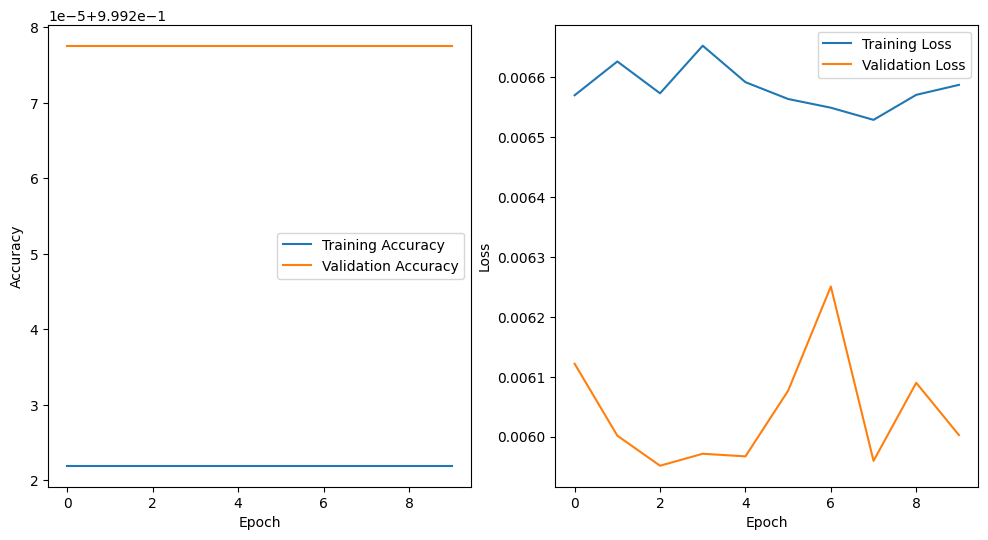

In [20]:
# %% Train the Model
# Ensure X_train and y_train are properly formatted
X_train = X_train.astype('float32') / 255.0  # Normalize pixel values to [0, 1]
y_train = y_train.astype('float32')

history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_split=0.2)

# Plot Training and Validation Performance
plt.figure(figsize=(12, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [21]:
# %% Save the Model
model_json = model.to_json()
with open("hybrid.json", "w") as json_file:
    json_file.write(model_json)
model.save("hybrid.h5")

print("Model saved to 'hybrid.h5'")


Model saved to 'hybrid.h5'
